In [1]:
import pandas as pd
pd.set_option("display.width", 380)
pd.set_option('max_colwidth', 200)

from langdetect import detect

from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#To handle warning
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
df = pd.read_csv("./dataLemmatized.csv", sep=',')

## Distribution of articles over the years
With an average of 73 articles per year for a standard deviation of 18, there is a difference between years, but it is reasonable.

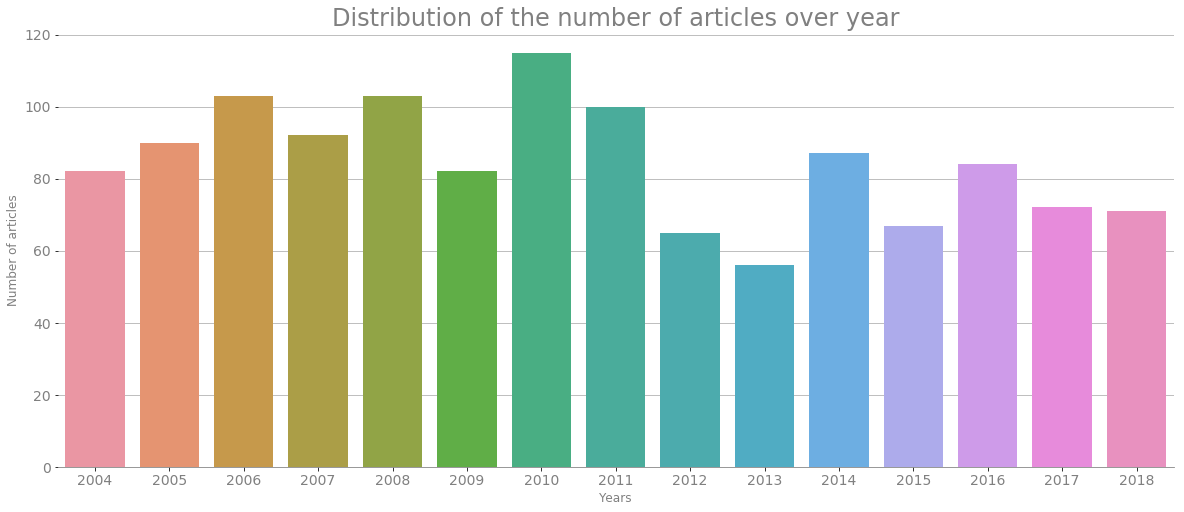

Grand total of 1269 articles


In [3]:
invYr = df.groupby(['year']).count()
sns.barplot(x=invYr.index, y=invYr.series)
plt.title("Distribution of the number of articles over year", fontsize= 24, color='gray')
plt.ylabel("Number of articles", fontsize=12, color='gray')
plt.xlabel("Years", fontsize=12, color='gray')
fig=plt.gcf()
fig.set_size_inches(20,8)

## PlotSwagg ##
plt.yticks(fontsize=14, rotation=0, color='gray')
plt.xticks(fontsize=14, rotation=0, color='gray')

# Less border
plt.gca().yaxis.grid(True)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_edgecolor('gray')

# line under the bar
plt.gca().set_axisbelow(True)

plt.show()
print("Grand total of %d articles" % len(df))

## Language used in the articles

In [4]:
df['lng_title'] = df['title'].apply( lambda x : detect(x))
df['lng_abstract'] = df['abstract'].apply( lambda x : detect(x) if x is not pd.np.nan else pd.np.nan)

In [5]:
display(df[['title', 'abstract', 'lng_title', 'lng_abstract']].head(10))
print("French  title: {}\nEnglish title {}\n\nFrench  abstract {}\nEnglish abstract {}".format(
   len(df[df['lng_title'] == 'fr']), 
   len(df[df['lng_title'] == 'en']) ,
   len(df[df['lng_abstract'] == 'fr']) ,
   len(df[df['lng_abstract'] == 'en'])))


,title,abstract,lng_title,lng_abstract
0,#Idéo2017 : une plateforme citoyenne dédiée à l'analyse des tweets lors des événements politiques,"Cette plateforme a pour objectif de permettre aux citoyens d'analyserpar eux-mêmes les tweets politiques lors d'événements spécifiques en France.Pour le cas de l'élection présidentielle de 2017, #...",fr,fr
1,A two level co-clustering algorithm for very large data sets,La classification croisée (co-clustering) est une technique qui permet d'extraire la structuresous-jacente existante entre les lignes et les colonnes d'une table de données sous forme de blocs. Pl...,en,fr
2,ALGeoSPF: Un modèle de factorisation basé sur du clustering géographique pour la recommandation de POI,La recommandation de points d'intérêts est devenue une caractéristiqueessentielle des réseaux sociaux géo-localisés qui a accompagnél'émergence des échanges massifs de données digitales. Cependant...,fr,fr
3,Analyse des sentiments à partir des commentaires Facebook publiés en Arabe standard ou dialectal marocain par une approche d'apprentissage automatique,"L'analyse des sentiments est un processus pendant lequel la polarité(positive, négative ou neutre) d'un texte donné est déterminée. Nous nous intéressonsdans ce travail à l'analyse des sentiments ...",fr,fr
4,Analyse en rôles sémantiques pour le résumé automatique,Cet article présente une approche visant à extraire les informations expriméesdans un corpus de textes et en produire un résumé. Plusieurs variantes deméthodes extractives de résumé de texte ont é...,fr,fr
5,Analyse Ontologique de scénario dans un contexte Big Data,NaN,fr,NaN
6,Apport de la fouille de données pour la prévention du risque suicidaire,"Avec plus de 800 000 décès par an dans le monde, le suicide est latroisième cause de décès évitable. Il y a 20 fois plus de tentatives, impliquant denombreuses hospitalisations, des coûts humains ...",fr,fr
7,Apport des modèles locaux pour les K-moyennes prédictives,"Dans le cadre du clustering prédictif, pour attribuer la classe aux groupesformés à la fin de la phase d'apprentissage, le vote majoritaire est la méthodecommunément utilisée. Cependant, cette app...",fr,fr
8,Apprendre les relations de préférence et de co-occurrence entre les labels en classification multi-labels,"En classification multi-labels, chaque instance est associée àun ou plusieurs labels. Par exemple, un morceau de musique peut êtreassocié aux labels 'heureux' et 'relaxant'. Des relations de co-oc...",fr,fr
9,Approche contextuelle par régression pour les tests A/B,"Les tests A/B sont des procédures utilisées par les entreprises du webet de la santé entre autres, pour mesurer l'impact d'un changement de versiond'une variable par rapport à un objectif. Bien qu...",fr,fr


French  title: 1132
English title 121

French  abstract 991
English abstract 105


## Lemmatization and tokenization was performed beforehand

In [6]:
# For French
df_fr_title = df[df['lng_title'] == 'fr']
df_fr_abstract = df[df['lng_abstract'] == 'fr']

# Do the French Lem and Prepros
df['lem_prepro_title'] = df['titleLemma']
df['lem_prepro_abstract'] =  df['abstractLemma']

# Display the result
display(df[['lng_title', 'lng_abstract' ,'lem_prepro_title' ,'lem_prepro_abstract']].head())

,lng_title,lng_abstract,lem_prepro_title,lem_prepro_abstract
0,fr,fr,plateforme citoyen dédiée analyser tweets événement politiques,plateforme objectif permettre citoyen analyserpar même tweets politiques événement spécifiques france élection présidentielle analyser quasitemps message candidat fournir principal caractéristique...
1,en,fr,algorithme clustering niveau grand ensemble donnée,classification croisée clustering technique permettre extraire structuresous jacente existante entre ligne colonne tabler donnée forme bloc plusieurs application utiliser technique cependant nombr...
2,fr,fr,algeospf modèle factorisation clustering géographique recommandation,recommandation point intérêt devenir caractéristiqueessentielle réseau sociaux localiser accompagnél émergence échange massif donnée digitale cependantles faible densités point intérêt visiter uti...
3,fr,fr,analyser sentiment partir commentaire facebook publier arabe standard dialectal marocain approche apprentissage automatique,analyser sentiment processus pendant lequel polarité positive négative neutre texte donner déterminée intéressonsdans travail analyser sentiment partir commentairesfacebook réel partager arabe sta...
4,fr,fr,analyser rôle sémantique résumer automatique,article présente approcher viser extraire information expriméesdans corpus texte produire résumer plusieurs variante deméthodes extractives résumer texte implémenter évaluer leurprincipale origina...


## Selection of the feature on which the analysis will be performed

In [7]:
# with ou without the abstract
WITH_ABST = True

def join_with_nan(subset_df):
    res = []
    if subset_df['lem_prepro_title'] is not pd.np.nan:
        res += subset_df['lem_prepro_title'].split()
    if WITH_ABST and subset_df['lem_prepro_abstract'] is not pd.np.nan:
        res += subset_df['lem_prepro_abstract'].split()
    return res

# Join the lematized title and abstract
df_all_lem = df.apply(join_with_nan, axis=1)
display(df_all_lem.head())


0    [plateforme, citoyen, dédiée, analyser, tweets, événement, politiques, plateforme, objectif, permettre, citoyen, analyserpar, même, tweets, politiques, événement, spécifiques, france, élection, pr...
1    [algorithme, clustering, niveau, grand, ensemble, donnée, classification, croisée, clustering, technique, permettre, extraire, structuresous, jacente, existante, entre, ligne, colonne, tabler, don...
2    [algeospf, modèle, factorisation, clustering, géographique, recommandation, recommandation, point, intérêt, devenir, caractéristiqueessentielle, réseau, sociaux, localiser, accompagnél, émergence,...
3    [analyser, sentiment, partir, commentaire, facebook, publier, arabe, standard, dialectal, marocain, approche, apprentissage, automatique, analyser, sentiment, processus, pendant, lequel, polarité,...
4    [analyser, rôle, sémantique, résumer, automatique, article, présente, approcher, viser, extraire, information, expriméesdans, corpus, texte, produire, résumer, plusieurs, vari

## Remove Stopwords

In [8]:
import gensim


# Custom Stop words
custom_stop_words = ['algorithme', 'étude', 'méthode', 'approche', 'nouvelle', 'algorithme', 'automatique', 'système'
                    'source', 'exemple', 'concevoir', 'ensuite', 'définir', 'effectuer', 'donnée', 'permettre', "ainsi", "entre",
                    'souvent', 'utiliser', 'variable', 'technique', 'masse']
df_all_lem = df_all_lem.apply(lambda word_list: [word for word in word_list if word not in custom_stop_words])

## Create the Dictionary and Corpus needed for Topic Modeling
[source](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [9]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(df_all_lem)

count = 0
for k, v in id2word.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 analyser
1 analyserpar
2 candidat
3 caractéristique
4 citoyen
5 comparaison
6 dédiée
7 fournir
8 france
9 lexique
10 message


## Remove tokens from the dictionary before Topic Modeling

In [10]:
# Filter out tokens that appear in 
id2word.filter_extremes(no_below=20,   # - less than X documents (absolute number)
                        no_above=0.90, # - more than X documents (fraction of total corpus size, not absolute number)
                        keep_n=1000)  # - after the above two steps, keep only the first X most frequent tokens.

bow_corpus = [id2word.doc2bow(doc) for doc in df_all_lem]

In [11]:
first_bow_doc = bow_corpus[0]

# Pandas df
display(", ".join(df_all_lem[0]))

# bow representation
for i in range(len(first_bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(first_bow_doc[i][0],
                                               id2word[first_bow_doc[i][0]],
                                               first_bow_doc[i][1]))

'plateforme, citoyen, dédiée, analyser, tweets, événement, politiques, plateforme, objectif, citoyen, analyserpar, même, tweets, politiques, événement, spécifiques, france, élection, présidentielle, analyser, quasitemps, message, candidat, fournir, principal, caractéristique, usage, lexique, politique, comparaison, candidat'

Word 0 ("analyser") appears 2 time.
Word 1 ("caractéristique") appears 1 time.
Word 2 ("comparaison") appears 1 time.
Word 3 ("fournir") appears 1 time.
Word 4 ("objectif") appears 1 time.
Word 5 ("plateforme") appears 2 time.
Word 6 ("principal") appears 1 time.
Word 7 ("spécifiques") appears 1 time.
Word 8 ("usage") appears 1 time.
Word 9 ("événement") appears 2 time.


## tf-idf

In [12]:
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    display(doc)
    break

[(0, 0.21730008356165073),
 (1, 0.2232381377599563),
 (2, 0.2232381377599563),
 (3, 0.19544526993449768),
 (4, 0.16677397960006982),
 (5, 0.5498414605392205),
 (6, 0.2028955335300639),
 (7, 0.27769410936303657),
 (8, 0.2749207302696102),
 (9, 0.539360799475047)]

## Building the Topic Model

In [13]:
USE_TF_IDF = True

corpus_for_lda = bow_corpus
if USE_TF_IDF:
    corpus_for_lda = corpus_tfidf

lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=200, id2word=id2word, passes=2,  workers=4)

In [14]:
for idx, topic in lda_model.print_topics(-1)[:5]:
    print('\nTopic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.052*"concept" + 0.043*"génération" + 0.029*"intervalle" + 0.025*"grand" + 0.022*"treillis" + 0.020*"généralisation" + 0.019*"classification" + 0.018*"machine" + 0.018*"ensemble" + 0.017*"traiter"

Topic: 1 
Words: 0.079*"entrepôt" + 0.063*"gestion" + 0.055*"projet" + 0.036*"connaissance" + 0.030*"également" + 0.029*"extraction" + 0.025*"information" + 0.021*"organisation" + 0.021*"outil" + 0.016*"présence"

Topic: 2 
Words: 0.031*"topologique" + 0.028*"qualité" + 0.023*"modèle" + 0.021*"apprentissage" + 0.019*"prototype" + 0.016*"groupe" + 0.016*"classification" + 0.016*"propriété" + 0.014*"multi" + 0.013*"nouveau"

Topic: 3 
Words: 0.043*"hypothèse" + 0.040*"motif" + 0.036*"problématique" + 0.025*"série" + 0.023*"voisinage" + 0.021*"textuelles" + 0.020*"représentation" + 0.017*"temporelles" + 0.016*"prédiction" + 0.015*"texte"

Topic: 4 
Words: 0.023*"voisinage" + 0.021*"spatiales" + 0.019*"préférence" + 0.019*"distribution" + 0.019*"interface" + 0.019*"règle" + 0.

## Visualize the topics-keywords

In [15]:
import pyLDAvis.gensim
from metakernel.display import display

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

## Evaluate LDA
The Coherence score is used for evaluation of topic models.  
[paper](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

In [16]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_all_lem, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.24513339444415153


## Find the optimal number of topics for LDA
Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.  
[source](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
if False:
    # Can take a long time to run.
    limit=900; start=50; step=20;
    model_list, coherence_values = compute_coherence_values(
        dictionary=id2word,
        corpus=bow_corpus,
        texts=df_all_lem,
        start=start,
        limit=limit,
        step=step)

    # Show graph
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    ### Print the coherence scores
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

## With the LDA's topics, perform a clustering algorithm

In [19]:
corpus_lda = lda_model[bow_corpus]

# gensim sparse matrix to scipy sparse matrix
lda_csc_matrix = gensim.matutils.corpus2csc(corpus_lda).transpose() 

## Kmeans takes the topics and reduce them to  ideas

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation

# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

print('LDA matrix shape (input to KMeans):', lda_csc_matrix.shape)

km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=4, verbose=False, random_state=10)
km.fit(lda_csc_matrix)

display(pd.DataFrame(km.labels_).T)

df['pred'] = km.labels_
n_clusters = km.n_clusters

LDA matrix shape (input to KMeans): (1269, 200)


,0,1,2,3,4,5,6,7,8,9,...,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268
0,6,3,6,9,6,3,9,0,6,6,...,3,8,1,6,6,6,2,1,1,3


In [21]:
class cluster_label():
    def __init__(self, topic_id, value, lda_model_words):
        self.topic_id = topic_id
        self.value = value
        self.words = lda_model_words[topic_id]
    def __repr__(self):
        return "{}".format(" ".join([word[0] for word in self.words[1]]))
        # return '{}: {} {} {}'.format(self.__class__.__name__,
                                  # self.topic_id,
                                  # self.value,
                                  # self.words
                                  #)
    def __cmp__(self, other):
        if hasattr(other, 'topic'):
            return self.topic_id.__cmp__(other.topic_id)

In [22]:
testing = {}
lda_words = lda_model.show_topics(-1, formatted=False)
for cluster in range(n_clusters):
    values_dence = lda_csc_matrix[np.where(df['pred'] == cluster)]
    coo = values_dence.tocoo()

    maximize = []
    for row, col in zip(coo.row, coo.col):
        label = cluster_label(col, values_dence.toarray()[row][col], lda_words)

        trigger = True

        for la in maximize:
            if la.topic_id == col and la.value < label.value:
                trigger = True
                maximize.remove(la)
                break

            if la.topic_id == col and la.value > label.value:
                trigger = False


        if trigger:
            maximize.append(label)

    first5 = (sorted(maximize, key=lambda x: x.value, reverse=True))[:5]


    testing[cluster] = first5

## Evaluate Kmeans
Silhouette refers to a method of interpretation and validation of consistency within clusters of data.  
[how-to-interpret-mean-of-silhouette-plot](https://stats.stackexchange.com/q/12923)

In [23]:
# Compute the SILHOUETTE score
silhouette_avg = metrics.silhouette_score(lda_csc_matrix, km.labels_)
print('Silhouette Coefficient:', silhouette_avg)

Silhouette Coefficient: 0.016590541572565322


## Distribution of idea over the years

In [24]:
# Year sampling, (-> ['2004 to 2006', '2007 to 2009', .. ])
NUM_OF_SEP = 10 # number of partition

In [25]:
# Group the year, while keeping the prediction dissimilarity AND count the number of article for onw prediction
A = df.groupby(['year', 'pred']).agg({'pred': ['count']})

# Result is MultiIndex dataframe
display(A.query('year <= 2006').T)

df_label_count_sampled_year = pd.DataFrame(index=[x for x in range(n_clusters)])

start = pd.Timestamp('2004')
end = pd.Timestamp('2018')
ye_sampling = np.linspace(start.value, end.value, NUM_OF_SEP)
ye_sampling = pd.to_datetime(ye_sampling).year

# For each year's partitions
for start, end in zip(ye_sampling[:-1], ye_sampling[1:]):
    
    # query the current partition into the df
    _splited_df = A.query('year >= '+ str(start) + ' & year < ' + str(end+1)) 
    
    # label conter for each year of the partition
    from collections import defaultdict
    class_count = {}
    class_count = defaultdict(lambda:0, class_count)
    
    for ((year, label_id, a), count_obj) in _splited_df.stack().iterrows():
        class_count[label_id] += count_obj[0]
        # VERBOSE
        # print("Year {} has a label {:3} documents related to the label id: {:3}".format(year, count_obj[0], label_id ))
        
    # total of document for each label of the current partition
    class_count = dict(class_count)
    # VERBOSE
    # display(class_count)
    
    df_label_count_sampled_year["{} - {}".format(start, end)] = pd.Series(class_count)
    
df_label_count_sampled_year = df_label_count_sampled_year.T
display(df_label_count_sampled_year)

year       2004                         2005     ... 2006                              
pred          0   1  2   3  4  5   6  8    0   1 ...    0   1  2   3  4  5   6  7  8  9
pred count    1  20  5  10  2  5  35  4    4  13 ...    6  14  1  13  2  8  52  3  2  2

[1 rows x 26 columns]

,0,1,2,3,4,5,6,7,8,9
2004 - 2005,5.0,33.0,5.0,18.0,3.0,11.0,87.0,NaN,9.0,1.0
2005 - 2007,16.0,45.0,3.0,28.0,3.0,18.0,144.0,4.0,18.0,6.0
2007 - 2008,11.0,37.0,8.0,17.0,NaN,6.0,93.0,1.0,18.0,4.0
2008 - 2010,16.0,46.0,10.0,28.0,3.0,11.0,153.0,4.0,24.0,5.0
2010 - 2011,12.0,37.0,10.0,12.0,2.0,10.0,111.0,3.0,14.0,4.0
2011 - 2013,23.0,37.0,14.0,24.0,2.0,8.0,97.0,3.0,10.0,3.0
2013 - 2014,16.0,25.0,7.0,12.0,2.0,1.0,63.0,2.0,14.0,1.0
2014 - 2016,24.0,32.0,11.0,15.0,3.0,1.0,120.0,5.0,23.0,4.0
2016 - 2018,17.0,27.0,9.0,17.0,2.0,2.0,123.0,1.0,22.0,7.0


{0: [topologique qualité modèle apprentissage prototype groupe classification propriété multi nouveau,
  informatique annotation optimisation outil nouvel similarité classification connaissance noyau problème,
  question orienter telle structure temps internet compter passage mesure recherche,
  règle ordre association résultat problème extraction fort motif tâche classe,
  ressource gestion règle stratégie connaissance document dépendance améliorer expérimentale accès],
 1: [graphe forme reconnaissance introduire document interrogation exprimer treillis domaine concept,
  enrichissement document enrichir critère classification image sémantique régression capteur acteur,
  pertinentes optimisation service temporelles extraction concept conserver événement associer automatiquement,
  recommandation raison annotation ontologie comportement système sémantique domaine apprentissage détecter,
  acteur nombre problème navigation interface complexe utilisation étendre modèle graphique],
 2: [

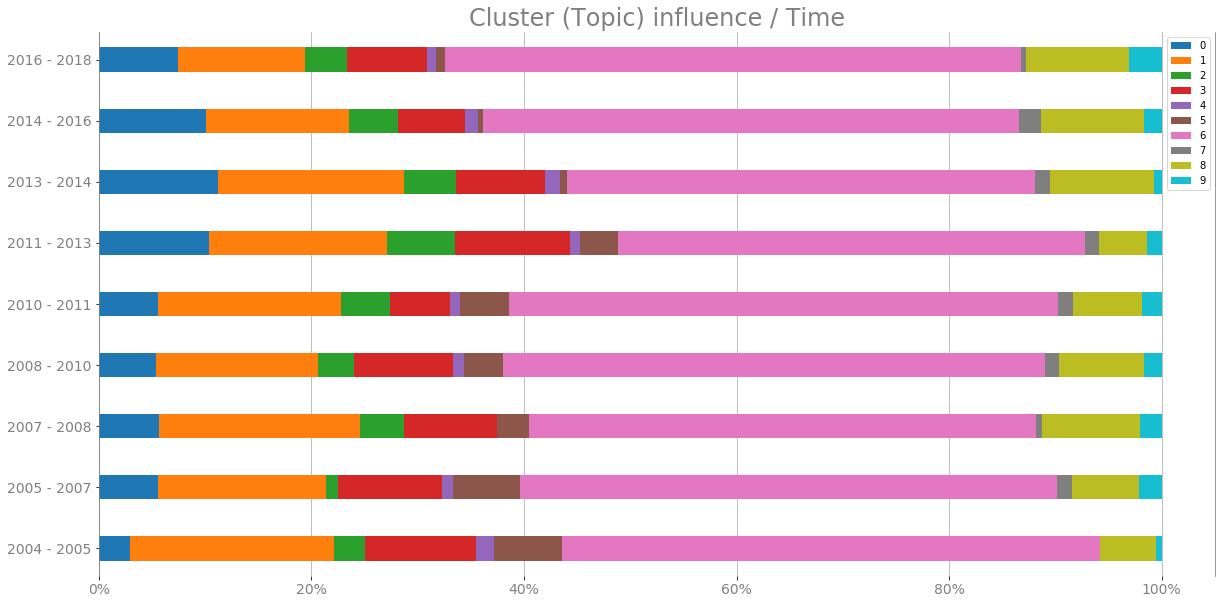

In [26]:
from matplotlib.ticker import FuncFormatter

# To percent
df_label_count_sampled_year = df_label_count_sampled_year.apply(lambda x: x / x.sum(), axis=1)

# Plot
df_label_count_sampled_year.plot.barh(stacked=True, figsize=(20, 10), width=0.4)
plt.title('Cluster (Topic) influence / Time', fontsize= 24, color='gray')

## PlotSwagg ##
plt.yticks(fontsize=14, rotation=0, color='gray')
plt.xticks(fontsize=14, rotation=0, color='gray')

# Cleanest Percent
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Less border
plt.gca().xaxis.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_edgecolor('gray')
plt.gca().spines['right'].set_edgecolor('gray')

# Percent line under the barH
plt.gca().set_axisbelow(True)

display(testing)
plt.show()

In [27]:
# Dump 
if False:
    lda_model.save('LDA_model.gensim')
    id2word.save('dictionary.gensim')
    import pickle
    pickle.dump(bow_corpus, open('corpus.pkl', 'wb'))